In [1]:
!pip install -q timm albumentations

import os
import cv2
import torch
import timm
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torchvision import models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Set paths
base_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

labels = ["glioma", "meningioma", "notumor", "pituitary"]

# Load image paths + labels
def collect_image_paths_labels(directory):
    image_paths, image_labels = [], []
    for idx, label in enumerate(labels):
        folder = os.path.join(directory, label)
        for img in os.listdir(folder):
            image_paths.append(os.path.join(folder, img))
            image_labels.append(idx)
    return pd.DataFrame({'path': image_paths, 'label': image_labels})

train_df = collect_image_paths_labels(train_dir)
val_df = collect_image_paths_labels(test_dir)


In [4]:
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)["image"]
        return image, label

train_ds = BrainTumorDataset(train_df, transform_train)
val_ds = BrainTumorDataset(val_df, transform_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [6]:
class DenseNetViTEnsemble(nn.Module):
    def __init__(self, num_classes=4):
        super(DenseNetViTEnsemble, self).__init__()

        # DenseNet169 Backbone
        self.densenet = models.densenet169(pretrained=True)
        self.densenet.classifier = nn.Identity()

        # Vision Transformer
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(1664 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        densenet_feat = self.densenet(x)
        vit_feat = self.vit(x)
        combined = torch.cat((densenet_feat, vit_feat), dim=1)
        return self.classifier(combined)


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Updated augmentations
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# Updated model training
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = total_correct / len(loader.dataset)
    return acc, total_loss, y_true, y_pred


def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=15):
    model.to(device)
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, 1)
            total_correct += (preds == labels).sum().item()

        train_acc = total_correct / len(train_loader.dataset)
        val_acc, val_loss, _, _ = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Plot accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15: 100%|██████████| 179/179 [05:18<00:00,  1.78s/it]


Epoch 1: Train Loss=48.2313, Train Acc=0.9067, Val Loss=3.6099, Val Acc=0.9664


Epoch 2/15: 100%|██████████| 179/179 [05:17<00:00,  1.77s/it]


Epoch 2: Train Loss=14.0954, Train Acc=0.9734, Val Loss=1.9004, Val Acc=0.9847


Epoch 3/15: 100%|██████████| 179/179 [05:17<00:00,  1.77s/it]


Epoch 3: Train Loss=10.7434, Train Acc=0.9788, Val Loss=2.6437, Val Acc=0.9741


Epoch 4/15: 100%|██████████| 179/179 [05:16<00:00,  1.77s/it]


Epoch 4: Train Loss=6.2105, Train Acc=0.9881, Val Loss=3.2152, Val Acc=0.9725


Epoch 5/15: 100%|██████████| 179/179 [05:20<00:00,  1.79s/it]


Epoch 5: Train Loss=6.0210, Train Acc=0.9900, Val Loss=0.9580, Val Acc=0.9954


Epoch 6/15: 100%|██████████| 179/179 [05:19<00:00,  1.79s/it]


Epoch 6: Train Loss=4.6266, Train Acc=0.9919, Val Loss=0.7980, Val Acc=0.9939


Epoch 7/15: 100%|██████████| 179/179 [05:16<00:00,  1.77s/it]


Epoch 7: Train Loss=6.0493, Train Acc=0.9897, Val Loss=0.4346, Val Acc=0.9962


Epoch 8/15: 100%|██████████| 179/179 [05:19<00:00,  1.79s/it]


Epoch 8: Train Loss=3.7566, Train Acc=0.9928, Val Loss=0.6112, Val Acc=0.9954


Epoch 9/15: 100%|██████████| 179/179 [05:20<00:00,  1.79s/it]


Epoch 9: Train Loss=3.1397, Train Acc=0.9958, Val Loss=0.4022, Val Acc=0.9962


Epoch 10/15: 100%|██████████| 179/179 [05:21<00:00,  1.79s/it]


Epoch 10: Train Loss=2.6346, Train Acc=0.9958, Val Loss=0.3516, Val Acc=0.9969


Epoch 11/15: 100%|██████████| 179/179 [05:21<00:00,  1.80s/it]


Epoch 11: Train Loss=2.7212, Train Acc=0.9963, Val Loss=0.3443, Val Acc=0.9977


Epoch 12/15: 100%|██████████| 179/179 [05:18<00:00,  1.78s/it]


Epoch 12: Train Loss=4.6005, Train Acc=0.9923, Val Loss=1.2457, Val Acc=0.9916


Epoch 13/15: 100%|██████████| 179/179 [05:20<00:00,  1.79s/it]


Epoch 13: Train Loss=2.5436, Train Acc=0.9949, Val Loss=0.9475, Val Acc=0.9947


Epoch 14/15: 100%|██████████| 179/179 [05:21<00:00,  1.80s/it]


Epoch 14: Train Loss=3.0274, Train Acc=0.9953, Val Loss=0.4864, Val Acc=0.9985


Epoch 15/15: 100%|██████████| 179/179 [05:23<00:00,  1.81s/it]


Epoch 15: Train Loss=0.6801, Train Acc=0.9988, Val Loss=0.4287, Val Acc=0.9985


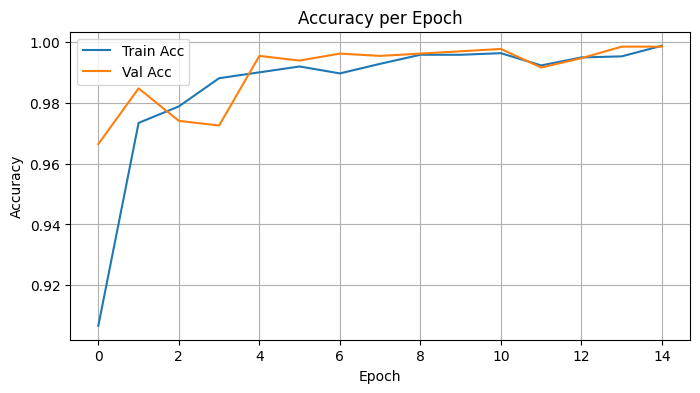

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetViTEnsemble(num_classes=4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=15)


In [15]:
# Save only the model weights
model_save_path = "/kaggle/working/fusion_densenet_vit_brain_tumor.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

# Optional: Save entire model (less preferred, but possible)
# torch.save(model, "/kaggle/working/fusion_densenet_vit_brain_tumor_full.pth")


Model weights saved to /kaggle/working/fusion_densenet_vit_brain_tumor.pth


In [8]:
from pathlib import Path

# Testing transforms (same as validation)
transform_test = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# Custom dataset loader
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = list(Path(root_dir).glob("*/*.jpg"))
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted({p.parent.name for p in self.paths}))}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(str(path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        label = self.label_map[path.parent.name]
        return image, label

# Create test dataset and loader
test_dataset = BrainTumorDataset("/kaggle/input/brain-tumor-mri-dataset/Testing", transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
# Load trained weights
model.load_state_dict(torch.load("/kaggle/working/fusion_densenet_vit_brain_tumor.pth"))
model.to(device)

# Run evaluation
test_acc, test_loss, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


/tmp/ipykernel_31/222324964.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/fusion_densenet_vit_brain_tumor.pth"))



🎯 Final Test Accuracy: 0.9985 | Test Loss: 0.4287
